In [1]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
from shutil import copy

In [ ]:
git clone https://github.com/ultralytics/yolov5

In [2]:
ls

datapreprocessing.ipynb  kangaroo-master/     raccoon_dataset-master/
dataset/                 kangaroo-master.zip  raccoon_dataset-master.zip


In [4]:
cd dataset

/home/afm/enjhih/side_project/project/dataset


## Data PreProcessing

In [ ]:
for root, dirs, files in os.walk("raccoon_dataset-master/images", topdown=False):
    print(len(files))
for root, dirs, files2 in os.walk("kangaroo-master/images", topdown=False):
    print(len(files2))

files.extend(files2)

In [ ]:
# ref: https://blog.csdn.net/duan19920101/article/details/105004691
file_path = "raccoon_dataset-master/images"
file_path2 = "kangaroo-master/images"
file_path_annot = "raccoon_dataset-master/annotations"
file_path2_annot = "kangaroo-master/annots"
train_dir = "train/images"
train_annot_dir = "train/annotations"
val_dir = "val/images"
val_annot_dir = "val/annotations"

pathDir = os.listdir(file_path)
pathDir2 = os.listdir(file_path2)
pathDir_annot = os.listdir(file_path_annot)
pathDir2_annot = os.listdir(file_path2_annot)
path1 = []
path2 = []

for i in range(len(pathDir)):
    path1.append((pathDir[i],pathDir_annot[i]))
for i in range(len(pathDir2)):
    path2.append((pathDir2[i],pathDir2_annot[i]))

for i, filename in enumerate(path1):
    from_path1 = os.path.join(file_path, filename[0])
    from_path2 = os.path.join(file_path_annot, filename[1])
    if i <= int(0.8*len(path1)):
        to_path1 = train_dir
        to_path2 = train_annot_dir
    else:
        to_path1 = val_dir
        to_path2 = val_annot_dir
    if not os.path.isdir(to_path1):
        os.makedirs(to_path1)
    if not os.path.isdir(to_path2):
        os.makedirs(to_path2)
    copy(from_path1, to_path1)
    copy(from_path2, to_path2)

for i, filename in enumerate(path2):
    from_path1 = os.path.join(file_path2, filename[0])
    from_path2 = os.path.join(file_path2_annot, filename[1])
    if i <= int(0.8*len(path2)):
        to_path1 = train_dir
        to_path2 = train_annot_dir
    else:
        to_path1 = val_dir
        to_path2 = val_annot_dir
    if not os.path.isdir(to_path1):
        os.makedirs(to_path1)
    if not os.path.isdir(to_path2):
        os.makedirs(to_path2)
    copy(from_path1, to_path1)
    copy(from_path2, to_path2)

In [ ]:
# ref: https://blog.paperspace.com/train-yolov5-custom-data/
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
print(extract_info_from_xml('train/annotations/00001.xml'))

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"kangaroo": 0, "raccoon": 1}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, status):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        # Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name_train = os.path.join("train/labels/", info_dict["filename"].replace("jpg", "txt"))
    save_file_name_val = os.path.join("val/labels/", info_dict["filename"].replace("jpg", "txt"))
    # Save the annotation to disk
    if status == 'train':
        print("\n".join(print_buffer), file= open(save_file_name_train, "w"))
    if status == 'val':
        print("\n".join(print_buffer), file= open(save_file_name_val, "w"))

In [ ]:
from tqdm import tqdm
# Get the annotations
annotations_train = [os.path.join('train/annotations', x) for x in os.listdir('train/annotations') if x[-3:] == "xml"]
annotations_val = [os.path.join('val/annotations', x) for x in os.listdir('val/annotations') if x[-3:] == "xml"]
annotations_train.sort()
annotations_val.sort()

# Convert and save the annotations
for ann in tqdm(annotations_train):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict, 'train')
    
for ann in tqdm(annotations_val):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict, 'val')
# annotations = [os.path.join('train/annotations', x) for x in os.listdir('train/annotations') if x[-3:] == "txt"]

In [3]:
cd ../

/home/afm/enjhih/side_project


In [4]:
cd yolov5

/home/afm/enjhih/side_project/yolov5


In [5]:
ls

benchmarks.py    detect.py   __pycache__/      segment/        val.py
CITATION.cff     export.py   README.md         setup.cfg       wandb/
classify/        hubconf.py  README.zh-CN.md   train.py        yolov5s.pt
CONTRIBUTING.md  LICENSE     requirements.txt  tutorial.ipynb
data/            models/     runs/             utils/


## Train

In [6]:
!python3 train.py --img 416 --batch 16 --workers 2 --epochs 100 --data /home/afm/enjhih/side_project/project/dataset/data.yaml --weights yolov5s.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=yolov5s.pt, cfg=, data=/home/afm/enjhih/side_project/project/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce R

       3/99      1.96G    0.06424    0.02445    0.01313         30        416: 100%|██████████| 19/19 [00:01<00:00, 13.94it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00,  9.88it/s]
                   all         71         95      0.585      0.547      0.587      0.279

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       4/99      1.96G    0.06379    0.02151    0.00937         31        416: 100%|██████████| 19/19 [00:01<00:00, 14.04it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]
                   all         71         95      0.434      0.549      0.499      0.245

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       5/99      1.96G    0.06024    0.02041   0.007721         24        416: 100%|██████████| 19/19 [00:01<00:00, 13.35it/s]
           

      22/99      1.96G    0.03534    0.01729   0.003273         23        416: 100%|██████████| 19/19 [00:01<00:00, 13.65it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00,  9.97it/s]
                   all         71         95      0.869      0.897       0.94      0.609

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      23/99      1.96G    0.03524    0.01751   0.002671         31        416: 100%|██████████| 19/19 [00:01<00:00, 13.77it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]
                   all         71         95       0.87      0.903      0.939       0.57

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      24/99      1.96G    0.03718    0.01731   0.002971         35        416: 100%|██████████| 19/19 [00:01<00:00, 14.26it/s]
           

      41/99      1.96G    0.02932     0.0155   0.001964         28        416: 100%|██████████| 19/19 [00:01<00:00, 14.26it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 11.27it/s]
                   all         71         95      0.903      0.919      0.958      0.651

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      42/99      1.96G    0.02924     0.0149   0.003717         22        416: 100%|██████████| 19/19 [00:01<00:00, 13.86it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]
                   all         71         95      0.967      0.888      0.957      0.639

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      43/99      1.96G    0.03013    0.01559   0.002098         30        416: 100%|██████████| 19/19 [00:01<00:00, 13.82it/s]
           

      60/99      1.96G    0.02487    0.01348   0.001071         30        416: 100%|██████████| 19/19 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]
                   all         71         95      0.954      0.898       0.95      0.658

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      61/99      1.96G    0.02586    0.01473   0.001192         23        416: 100%|██████████| 19/19 [00:01<00:00, 14.10it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]
                   all         71         95      0.921      0.871       0.94      0.662

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      62/99      1.96G    0.02384    0.01445   0.001107         31        416: 100%|██████████| 19/19 [00:01<00:00, 14.44it/s]
           

      79/99      1.96G    0.02065    0.01294  0.0008494         27        416: 100%|██████████| 19/19 [00:01<00:00, 14.03it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]
                   all         71         95      0.978      0.911      0.971       0.69

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      80/99      1.96G    0.02153    0.01313    0.00053         27        416: 100%|██████████| 19/19 [00:01<00:00, 14.41it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 11.00it/s]
                   all         71         95      0.927      0.936      0.969      0.685

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      81/99      1.96G    0.02171    0.01276  0.0007889         25        416: 100%|██████████| 19/19 [00:01<00:00, 14.34it/s]
           

      98/99      1.96G    0.01929    0.01171   0.001352         29        416: 100%|██████████| 19/19 [00:01<00:00, 13.83it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.28it/s]
                   all         71         95      0.921      0.942      0.967      0.714

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      99/99      1.96G    0.01835    0.01133  0.0008047         26        416: 100%|██████████| 19/19 [00:01<00:00, 14.39it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:00<00:00, 10.58it/s]
                   all         71         95      0.921      0.944      0.967      0.708

100 epochs completed in 0.054 hours.
Optimizer stripped from runs/train/exp11/weights/last.pt, 14.3MB
Optimizer stripped from runs/train/exp11/weights/best.pt, 14.3MB

Validating runs/train/exp11/weights/best.pt...
F

## Inference

In [16]:
!python3 detect.py --weights /home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt --conf 0.5 --source /home/afm/enjhih/side_project/project/dataset/val/images/00151.jpg

detect: weights=['/home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt'], source=/home/afm/enjhih/side_project/project/dataset/val/images/00151.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /home/afm/enjhih/side_project/project/dataset/val/images/00151.jpg: 416x640 1 kangaroo, 7.3ms
Speed: 0.2ms pre-process, 7.3ms inference, 0.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


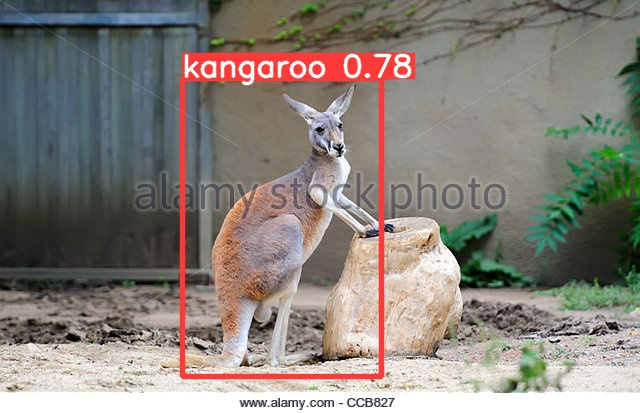

In [17]:
# visualize validation data
img = Image.open("/home/afm/enjhih/side_project/yolov5/runs/detect/exp3/00151.jpg")
img

## Running video
- kangeroo video was downloaded from: https://www.pexels.com/video/kangaroos-feeding-on-grass-5739695/  
- raccoon video was downloaded from: https://pixabay.com/videos/raccoon-mammal-wildlife-animal-81448/  

In [14]:
!python3 detect.py --weights /home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt --conf 0.5 --source /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4

detect: weights=['/home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt'], source=/home/afm/enjhih/side_project/project/dataset/kangaroo.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 10.2ms
video 1/1 (2/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (3/424) /home/afm/enjhih/side_p

video 1/1 (72/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.6ms
video 1/1 (73/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.8ms
video 1/1 (74/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (75/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.6ms
video 1/1 (76/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (77/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.6ms
video 1/1 (78/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.6ms
video 1/1 (79/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (80/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (81/424) /home/afm/enjhih/side_proje

video 1/1 (150/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.4ms
video 1/1 (151/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.6ms
video 1/1 (152/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.1ms
video 1/1 (153/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.8ms
video 1/1 (154/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.3ms
video 1/1 (155/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (156/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.7ms
video 1/1 (157/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (158/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.2ms
video 1/1 (159/424) /home/afm/enjhih/

video 1/1 (227/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (228/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (229/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.1ms
video 1/1 (230/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.9ms
video 1/1 (231/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (232/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.1ms
video 1/1 (233/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (234/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.3ms
video 1/1 (235/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (236/424) /home/afm/enjhih/

video 1/1 (306/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.2ms
video 1/1 (307/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.1ms
video 1/1 (308/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.3ms
video 1/1 (309/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.2ms
video 1/1 (310/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (311/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.2ms
video 1/1 (312/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (313/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.1ms
video 1/1 (314/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.0ms
video 1/1 (315/424) /home/afm/enjhih/

video 1/1 (385/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 6.2ms
video 1/1 (386/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 8.1ms
video 1/1 (387/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.8ms
video 1/1 (388/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (389/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.9ms
video 1/1 (390/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.7ms
video 1/1 (391/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.7ms
video 1/1 (392/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.8ms
video 1/1 (393/424) /home/afm/enjhih/side_project/project/dataset/kangaroo.mp4: 384x640 2 kangaroos, 5.5ms
video 1/1 (394/424) /home/afm/enjhih/

In [15]:
!python3 detect.py --weights /home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt --conf 0.5 --source /home/afm/enjhih/side_project/project/dataset/raccoon.mp4

detect: weights=['/home/afm/enjhih/side_project/yolov5/runs/train/exp7/weights/best.pt'], source=/home/afm/enjhih/side_project/project/dataset/raccoon.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 (no detections), 10.2ms
video 1/1 (2/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 (no detections), 6.2ms
video 1/1 (3/348) /home/afm/enjhih/s

video 1/1 (72/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.6ms
video 1/1 (73/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 (no detections), 6.3ms
video 1/1 (74/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 (no detections), 5.9ms
video 1/1 (75/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.5ms
video 1/1 (76/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.0ms
video 1/1 (77/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.8ms
video 1/1 (78/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (79/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.7ms
video 1/1 (80/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.7ms
video 1/1 (81/348) /home/afm/enjhih/side_project/project/data

video 1/1 (151/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.0ms
video 1/1 (152/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (153/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.7ms
video 1/1 (154/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (155/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.4ms
video 1/1 (156/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.7ms
video 1/1 (157/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (158/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (159/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (160/348) /home/afm/enjhih/side_project/project/datase

video 1/1 (230/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.2ms
video 1/1 (231/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 2 raccoons, 6.3ms
video 1/1 (232/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.8ms
video 1/1 (233/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.1ms
video 1/1 (234/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.3ms
video 1/1 (235/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 7.2ms
video 1/1 (236/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.0ms
video 1/1 (237/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 2 raccoons, 6.0ms
video 1/1 (238/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 2 raccoons, 5.6ms
video 1/1 (239/348) /home/afm/enjhih/side_project/project/dat

video 1/1 (310/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 7.5ms
video 1/1 (311/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 7.2ms
video 1/1 (312/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (313/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.6ms
video 1/1 (314/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 7.5ms
video 1/1 (315/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.6ms
video 1/1 (316/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.5ms
video 1/1 (317/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 6.0ms
video 1/1 (318/348) /home/afm/enjhih/side_project/project/dataset/raccoon.mp4: 384x640 1 raccoon, 5.9ms
video 1/1 (319/348) /home/afm/enjhih/side_project/project/datase

In [10]:
from ipywidgets import Video
video_kangaroo = Video.from_file("/home/afm/enjhih/side_project/yolov5/runs/detect/exp/kangaroo.mp4")
video_raccoon = Video.from_file("/home/afm/enjhih/side_project/yolov5/runs/detect/exp2/raccoon.mp4")

In [11]:
video_kangaroo

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x02\x17"Cmdat\x00\x00\x…

In [12]:
video_raccoon

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x04fE\xa1mdat\x00\x00\x…